<a href="https://colab.research.google.com/github/mittyone/JSCCR-fStageII/blob/main/npj_Statistical_analysis%2C_JSCCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lifelines


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.2/349.2 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.2/94.2 kB 3.2 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=57642abead03ba7c90faab20e2537f7e0209fdb1524964eb42b3fa00ec768fdc
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


In [ ]:
import pandas as pd
from lifelines import CoxPHFitter

df = pd.read_excel('JSCCR fStageII.xlsx')

In [ ]:
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter

# Assuming df is already defined

# Initialization of the Cox Proportional Hazards Model
cph = CoxPHFitter()

# Empty DataFrame to store the results
summary_df = pd.DataFrame()

# List of variables
variables = ['gender', 'age', 'Approach', 'operation', 'Dissection Level', 'Location',
             'Obstruction', 'Pathology', 'pDepth', 'ly', 'v', 'CEA', 'LN number']

# Create dummy variables for all categorical variables
df_dummy = pd.get_dummies(df, columns=variables, drop_first=True)

# Perform univariate analysis
for var in df_dummy.columns.drop(['DFS', 'Event']):
    cph.fit(df_dummy[['DFS', 'Event', var]], 'DFS', event_col='Event')
    # Extract the results
    coef = cph.summary.loc[var, 'coef']
    coef_lower_95 = cph.summary.loc[var, 'coef lower 95%']
    coef_upper_95 = cph.summary.loc[var, 'coef upper 95%']
    row = cph.summary.loc[var, ['exp(coef)', 'p']]
    row['exp(coef) lower 95%'] = np.exp(coef_lower_95)
    row['exp(coef) upper 95%'] = np.exp(coef_upper_95)
    row.name = var
    # Append the row to summary_df
    summary_df = pd.concat([summary_df, pd.DataFrame(row).T])

# Display the summary table
print(summary_df)


                    exp(coef)         p  exp(coef) lower 95%  \
gender_2             1.053776  0.247354             0.964286   
age_2                1.072179  0.135745             0.978367   
Approach_2           1.030014  0.605800             0.920593   
Approach_99          0.866893  0.202777             0.695834   
operation_2          0.985502  0.868139             0.829434   
operation_3          0.995138  0.922370             0.902219   
operation_4          1.035678  0.681648             0.875958   
operation_5          0.997522  0.958657             0.908199   
operation_6          1.295078  0.134996             0.922664   
operation_7          0.968970  0.622998             0.854540   
Dissection Level_2   1.091366  0.070036             0.992869   
Dissection Level_3   1.031551  0.728444             0.865634   
Location_2           1.004166  0.926643             0.919112   
Obstruction_2        1.057776  0.212704             0.968339   
Obstruction_99       1.029158  0.754031 

In [ ]:
summary_df.to_excel('cox_model_univariate_analysis.xlsx')

In [ ]:
import pandas as pd
from lifelines import CoxPHFitter

# Assuming that the DataFrame 'df' already exists.
# Select only the necessary columns
df_selected = df[['Pathology', 'pDepth', 'ly', 'v', 'CEA', 'LN number','DFS', 'Event']]

# 'age', 'pDepth', 'LN number' are categorical variables, so convert them to dummy variables
df_dummies = pd.get_dummies(df_selected, columns=['Pathology', 'pDepth', 'ly', 'v', 'CEA', 'LN number'], drop_first=True)

# Apply the Cox Proportional Hazards Model
cph = CoxPHFitter()
cph.fit(df_dummies, duration_col='DFS', event_col='Event')
result = cph.summary

# Display the results
print(result)



                 coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                    
Pathology_2  0.021392   1.021622  0.046487       -0.069720        0.112504   
Pathology_3 -0.015789   0.984335  0.099632       -0.211065        0.179486   
pDepth_2     0.116624   1.123697  0.062860       -0.006579        0.239826   
pDepth_3     0.071715   1.074349  0.116934       -0.157470        0.300901   
ly_2        -0.018790   0.981386  0.046793       -0.110502        0.072922   
v_2          0.039653   1.040450  0.048653       -0.055704        0.135011   
CEA_2        0.040901   1.041749  0.047186       -0.051582        0.133384   
LN number_2  0.053625   1.055088  0.050624       -0.045596        0.152845   

             exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                                 
Pathology_2             0.932655             1.119076     0.0  0.4601

In [ ]:
result.to_excel('cox_model_selective_multivariate.xlsx')


In [ ]:
import pandas as pd
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt

# Load the data
df = pd.read_excel('JSCCR fStageII.xlsx')

# Set the categories for pDepth
df['pDepth_category'] = df['pDepth'].map({1: 'SS', 2: 'SE', 3: 'SI'})

# Set the categories for v
df['v_category'] = df['v'].map({1: 'v-', 2: 'v+'})

# Set the categories for LN number
df['LN_number_category'] = df['LN number'].map({1: '≥12', 2: '0-11'})

# Set the categories for age
df['age_category'] = df['age'].map({1: '<65 years old', 2: '≥65 years old'})

# Set the categories for LN number
df['Pathology_category'] = df['Pathology'].map({1: 'tub1, pap', 2: 'tub2', 3:'por, sig, undiff'})

# Set the categories for LN number
df['ly_category'] = df['ly'].map({1: 'ly-', 2: 'ly+'})

# Set the categories for LN number
df['CEA_category'] = df['CEA'].map({1: 'Below Cutoff ', 2: 'above Cutoff'})

# Set the categories for gender
df['sex_category'] = df['gender'].map({1: 'women ', 2: 'men'})

# Set the categories for obstruction
df['obstruction_category'] = df['Obstruction'].map({1: 'below 2/3 circumferential ', 2: 'subtotal, total circumferential', 99:'unknown'})

# Set the categories for Dissection Level
df['Dissection_Level_category'] = df['Dissection Level'].map({1: 'D3 dissection ', 2: 'D2 dissection', 3:'D1 dissection'})

# Set the categories for Dissection Level
df['Location_category'] = df['Location'].map({1: 'Right Colon ', 2: 'Left Colon'})

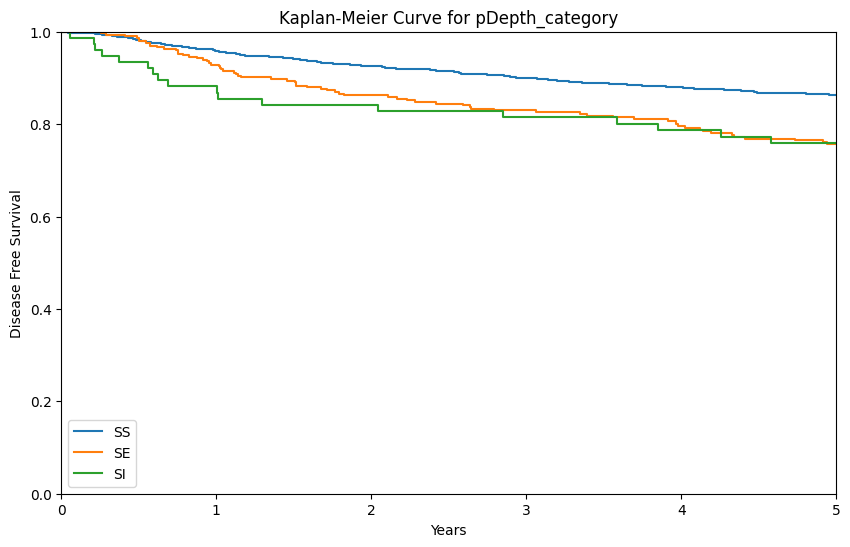

Log-rank test between SS and SE in pDepth_category: p = 0.0007
Log-rank test between SS and SI in pDepth_category: p = 0.2808
Log-rank test between SE and SI in pDepth_category: p = 0.5739


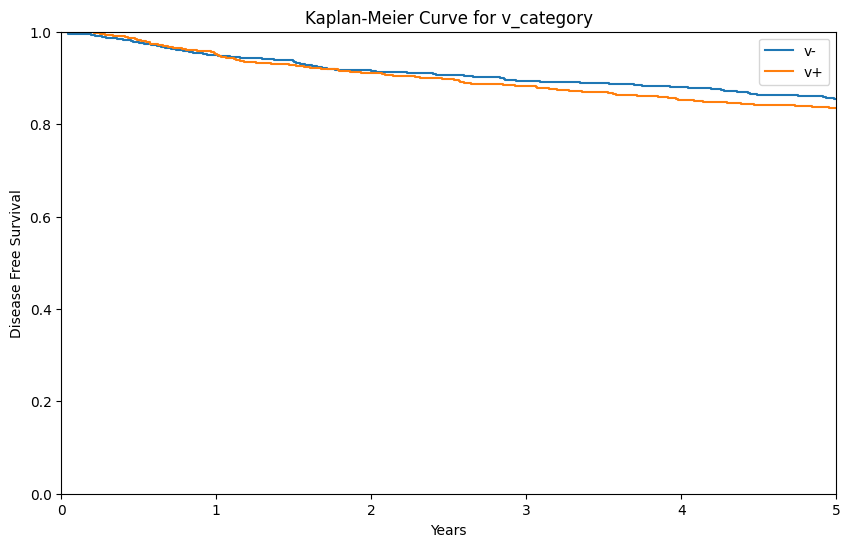

Log-rank test between v- and v+ in v_category: p = 0.1468


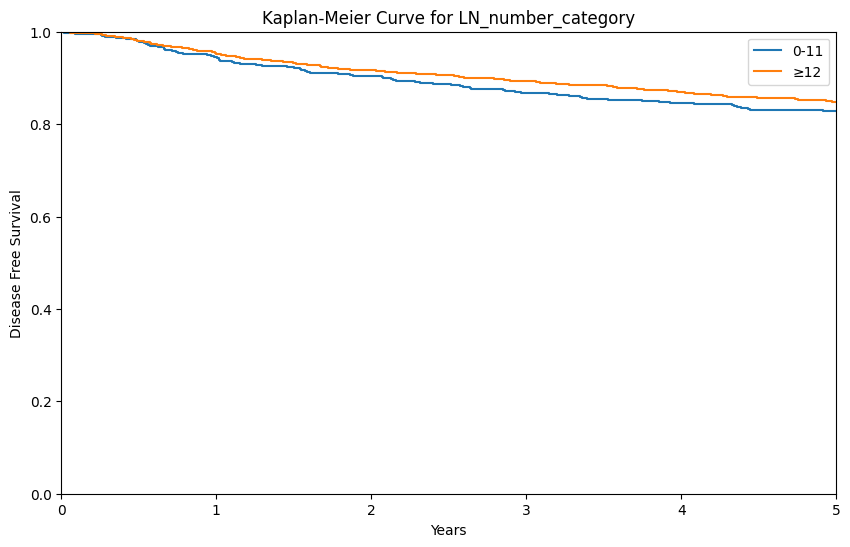

Log-rank test between 0-11 and ≥12 in LN_number_category: p = 0.0971


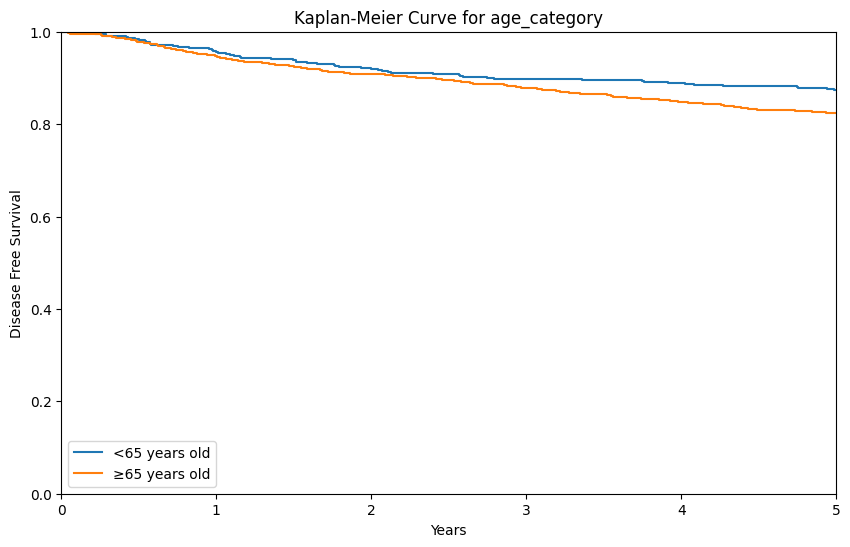

Log-rank test between <65 years old and ≥65 years old in age_category: p = 0.0077


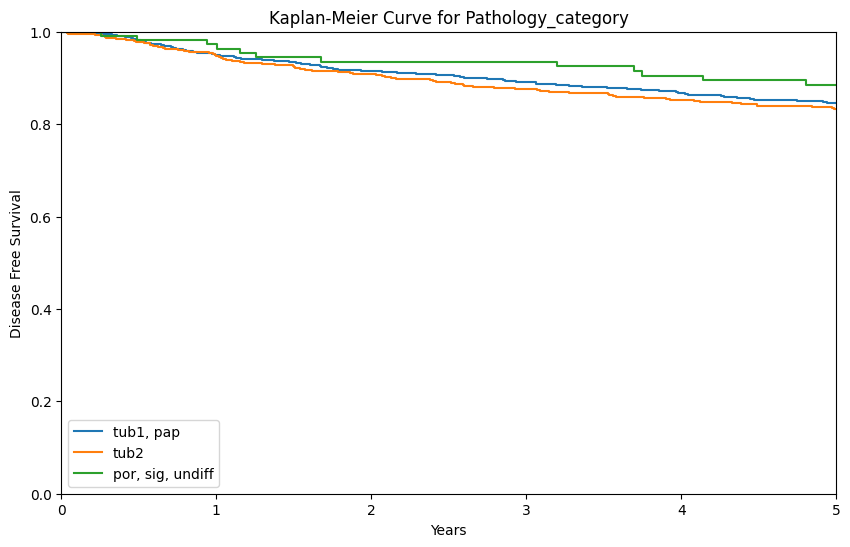

Log-rank test between tub1, pap and tub2 in Pathology_category: p = 0.4635
Log-rank test between tub1, pap and por, sig, undiff in Pathology_category: p = 0.6459
Log-rank test between tub2 and por, sig, undiff in Pathology_category: p = 0.4256


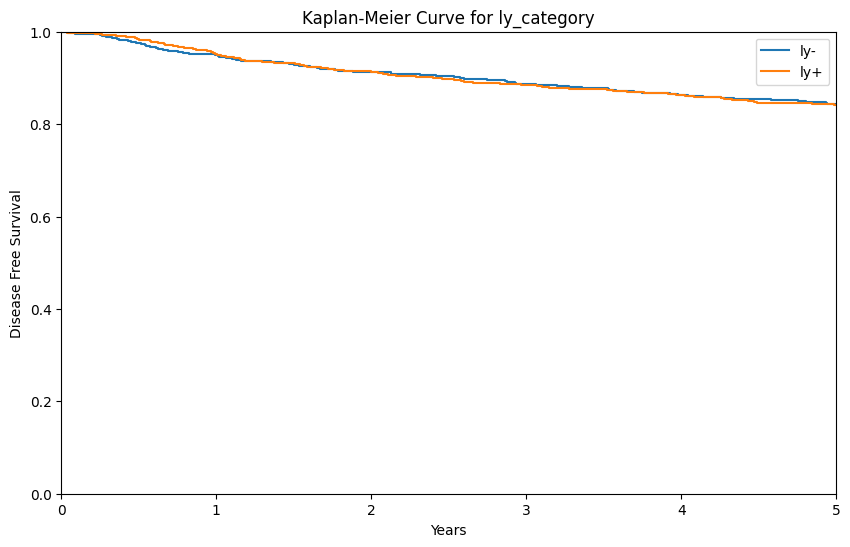

Log-rank test between ly- and ly+ in ly_category: p = 0.8692


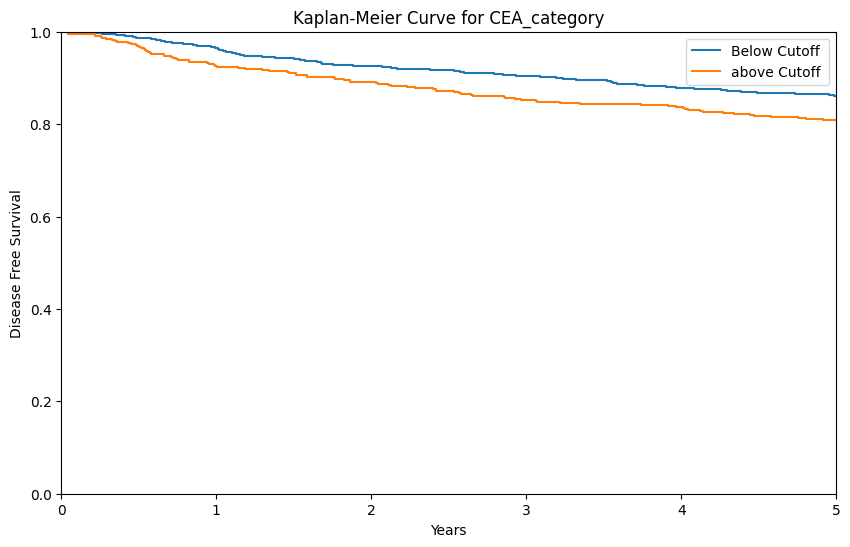

Log-rank test between Below Cutoff  and above Cutoff in CEA_category: p = 0.0962


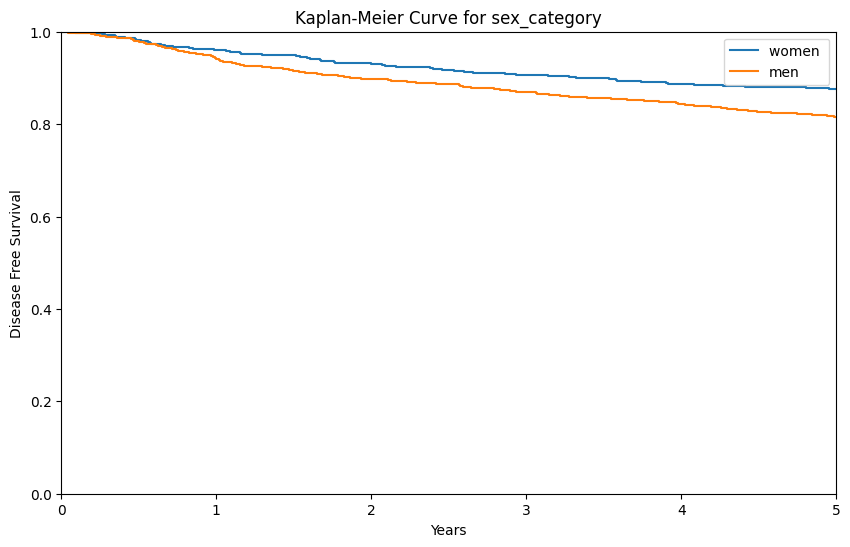

Log-rank test between women  and men in sex_category: p = 0.0395


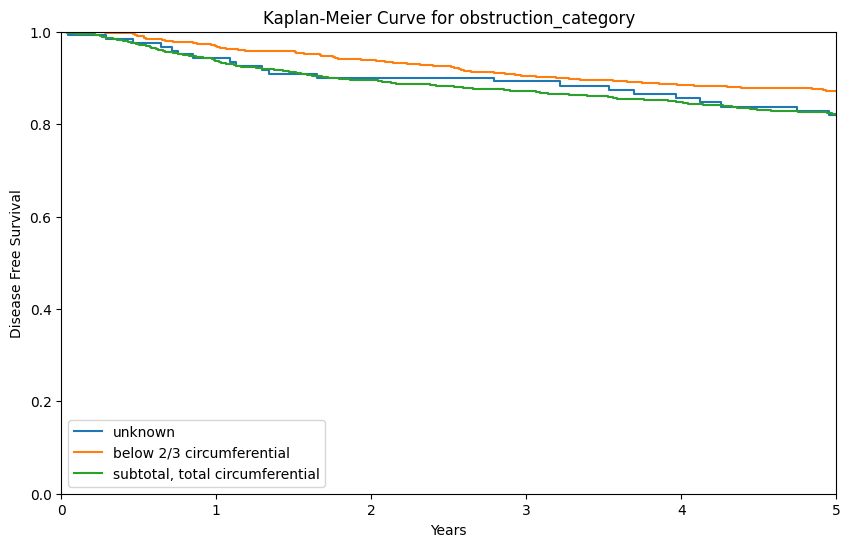

Log-rank test between unknown and below 2/3 circumferential  in obstruction_category: p = 0.2058
Log-rank test between unknown and subtotal, total circumferential in obstruction_category: p = 0.9908
Log-rank test between below 2/3 circumferential  and subtotal, total circumferential in obstruction_category: p = 0.0135


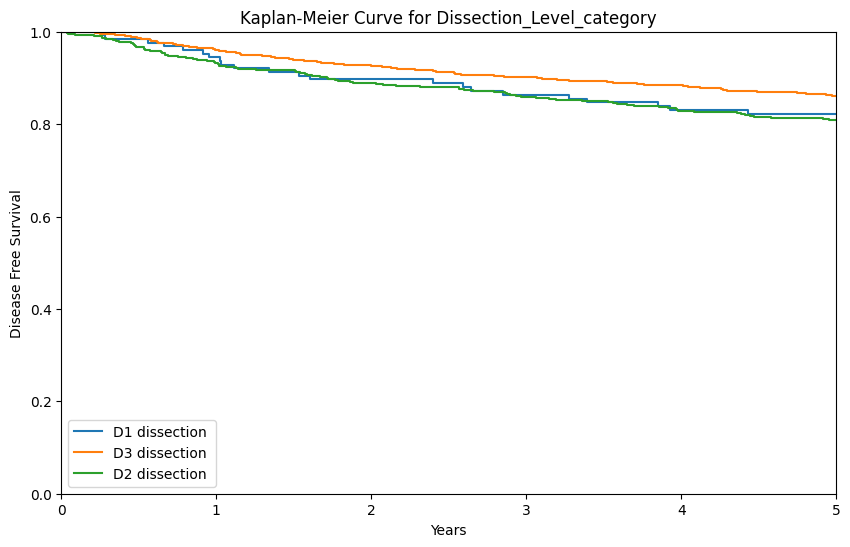

Log-rank test between D1 dissection and D3 dissection  in Dissection_Level_category: p = 0.2086
Log-rank test between D1 dissection and D2 dissection in Dissection_Level_category: p = 0.5973
Log-rank test between D3 dissection  and D2 dissection in Dissection_Level_category: p = 0.0007


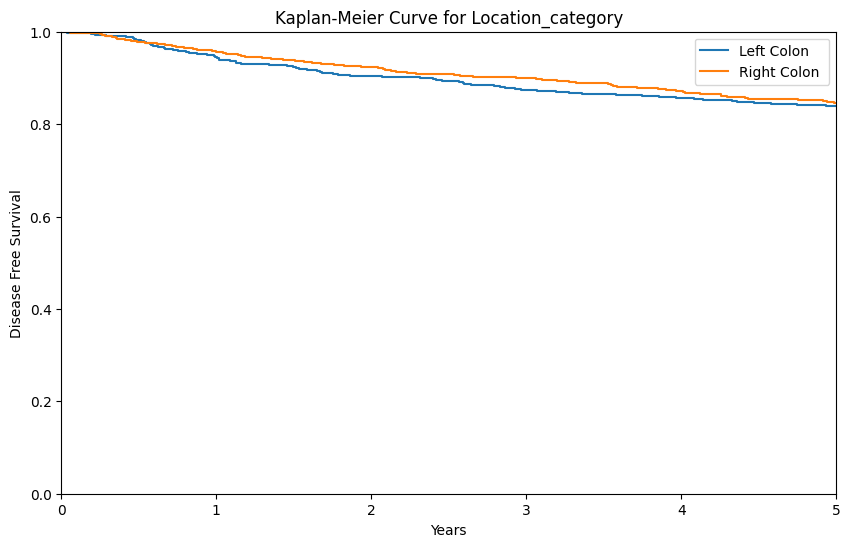

Log-rank test between Left Colon and Right Colon  in Location_category: p = 0.8697


In [ ]:
def plot_kaplan_meier(df, column):
    kmf = KaplanMeierFitter()
    plt.figure(figsize=(10, 6))

    for value in df[column].unique():
        mask = df[column] == value
        sub_df = df[mask].copy()  # Create a copy of the DataFrame

        # Transform event occurrence data: Change 1 (no event) to 0, and 2 (event occurred) to 1.
        sub_df['Event_transformed'] = sub_df['Event'].apply(lambda x: 0 if x == 1 else 1)

        # Fit the Kaplan-Meier fitter using the transformed event data.
        kmf.fit(sub_df['DFS'], sub_df['Event_transformed'], label=value)

        # Obtain the last time point.
        last_time_point = kmf.timeline[-1]

        # Plot the survival curve up to the last time point.
        kmf.plot(ci_show=False, xlim=(0, last_time_point))
        plt.ylim(0, 1)
    plt.title(f"Kaplan-Meier Curve for {column}")
    plt.xlabel("Years")
    plt.ylabel("Disease Free Survival")
    plt.legend()
    plt.show()

def logrank_test_by_group(df, column):
    groups = df[column].unique()
    for i in range(len(groups)):
        for j in range(i+1, len(groups)):
            group1 = df[df[column] == groups[i]]
            group2 = df[df[column] == groups[j]]
            results = logrank_test(group1['DFS'], group2['DFS'], event_observed_A=group1['Event'], event_observed_B=group2['Event'])
            print(f"Log-rank test between {groups[i]} and {groups[j]} in {column}: p = {results.p_value:.4f}")



# Kaplan-Meier curve and Log-rank test for pDepth_category
plot_kaplan_meier(df, 'pDepth_category')
logrank_test_by_group(df, 'pDepth_category')

# Kaplan-Meier curve and Log-rank test for v_category
plot_kaplan_meier(df, 'v_category')
logrank_test_by_group(df, 'v_category')

# Kaplan-Meier curve and Log-rank test for LN_number_category
plot_kaplan_meier(df, 'LN_number_category')
logrank_test_by_group(df, 'LN_number_category')

# Kaplan-Meier curve and Log-rank test for age_category
plot_kaplan_meier(df, 'age_category')
logrank_test_by_group(df, 'age_category')

# Kaplan-Meier curve and Log-rank test for Pathology_category
plot_kaplan_meier(df, 'Pathology_category')
logrank_test_by_group(df, 'Pathology_category')

# Kaplan-Meier curve and Log-rank test for ly_category
plot_kaplan_meier(df, 'ly_category')
logrank_test_by_group(df, 'ly_category')

# Kaplan-Meier curve and Log-rank test for CEA_category
plot_kaplan_meier(df, 'CEA_category')
logrank_test_by_group(df, 'CEA_category')

# Kaplan-Meier curve and Log-rank test for gender
plot_kaplan_meier(df, 'sex_category')
logrank_test_by_group(df, 'sex_category')

# Kaplan-Meier curve and Log-rank test for obstruction
plot_kaplan_meier(df, 'obstruction_category')
logrank_test_by_group(df, 'obstruction_category')

# Kaplan-Meier curve and Log-rank test for Dissection Level
plot_kaplan_meier(df, 'Dissection_Level_category')
logrank_test_by_group(df, 'Dissection_Level_category')

# Kaplan-Meier curve and Log-rank test for Dissection Level
plot_kaplan_meier(df, 'Location_category')
logrank_test_by_group(df, 'Location_category')



In [ ]:
import pandas as pd
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

def survival_counts_by_time(df, column, times=[0, 1, 2, 3, 4, 5]):
    kmf = KaplanMeierFitter()
    results_df = pd.DataFrame(index=times)

    for value in df[column].unique():
        mask = df[column] == value
        sub_df = df[mask].copy()

        # Transform event occurrence data
        sub_df['Event_transformed'] = sub_df['Event'].apply(lambda x: 0 if x == 1 else 1)

        # Fit KM model
        kmf.fit(sub_df['DFS'], sub_df['Event_transformed'], label=value)

        # Calculate number of survivals at specified times
        survival_prob = kmf.survival_function_.reindex(times, method='ffill')
        survivals = (survival_prob * len(sub_df)).astype(int)

        results_df[value] = survivals.values.flatten()

    results_df.columns = [f'{column} - {col}' for col in results_df.columns]
    return results_df

# Gather survival counts data for different categories
pDepth_counts = survival_counts_by_time(df, 'pDepth_category')
v_counts = survival_counts_by_time(df, 'v_category')
LN_number_counts = survival_counts_by_time(df, 'LN_number_category')
age_counts = survival_counts_by_time(df, 'age_category')
Pathology_counts = survival_counts_by_time(df, 'Pathology_category')
ly_counts = survival_counts_by_time(df, 'ly_category')
CEA_counts = survival_counts_by_time(df, 'CEA_category')
gender_counts = survival_counts_by_time(df, 'gender_category')
obstruction_counts = survival_counts_by_time(df, 'obstruction_category')
Dissection_Level_counts = survival_counts_by_time(df, 'Dissection_Level_category')
Location_counts = survival_counts_by_time(df, 'Location_category')

# Combine all results into one DataFrame
all_counts = pd.concat([pDepth_counts, v_counts, LN_number_counts, age_counts, Pathology_counts, ly_counts, CEA_counts, gender_counts, obstruction_counts, Dissection_Level_counts, Location_counts], axis=1)

# Transpose the DataFrame to match the requested Excel format
all_counts_transposed = all_counts.transpose()

# Save to Excel
all_counts_transposed.to_excel('survival_counts_by_category_transposed.xlsx')

# Confirm the file has been saved
print("Data saved to 'survival_counts_by_category_transposed.xlsx'.")

# Display the transposed DataFrame in Google Colab
all_counts_transposed



Data saved to 'survival_counts_by_category_transposed.xlsx'.


,0,1,2,3,4,5
pDepth_category - SS,1595,1527,1477,1435,1402,1375
pDepth_category - SE,306,284,263,253,243,231
pDepth_category - SI,78,68,65,63,61,59
v_category - v-,697,661,638,622,613,595
v_category - v+,1282,1219,1168,1130,1093,1071
LN_number_category - 0-11,546,515,493,473,461,452
LN_number_category - >=12,1433,1364,1314,1279,1245,1214
age_category - <65 years old,721,689,664,647,640,629
age_category - 65<= years old,1258,1191,1142,1105,1067,1036
"Pathology_category - tub1, pap",949,901,868,844,823,802


all_counts


In [ ]:
# Create an instance of KaplanMeierFitter
kmf = KaplanMeierFitter()

# List of categories
categories = [
    'pDepth_category', 'v_category', 'LN_number_category', 'age_category',
    'Pathology_category', 'ly_category', 'CEA_category', 'gender_category',
    'obstruction_category', 'Dissection_Level_category', 'Location_category'
]

# Ensure results_df is a DataFrame
results_df = pd.DataFrame(columns=['Category', 'Value', '5-Year DFS (%)'])

# Loop through each category
for category in categories:
    print(f"--- {category} ---")
    for value in df[category].unique():
        mask = df[category] == value
        # Transform event occurrence data
        event_observed_transformed = df.loc[mask, 'Event'].apply(lambda x: 0 if x == 1 else 1)
        # Fit the model with survival time data and transformed event occurrence data
        kmf.fit(durations=df.loc[mask, 'DFS'], event_observed=event_observed_transformed)
        # Predict the 5-year survival probability
        survival_probability_at_5_years = kmf.predict(5)
        # Print the prediction results
        print(f"{value} category: 5-year DFS = {survival_probability_at_5_years*100:.2f}%")


--- pDepth_category ---
SS category: 5-year DFS = 86.24%
SE category: 5-year DFS = 75.69%
SI category: 5-year DFS = 75.82%
--- v_category ---
v- category: 5-year DFS = 85.38%
v+ category: 5-year DFS = 83.58%
--- LN_number_category ---
0-11 category: 5-year DFS = 82.82%
>=12 category: 5-year DFS = 84.73%
--- age_category ---
<65 years old category: 5-year DFS = 87.37%
65<= years old category: 5-year DFS = 82.39%
--- Pathology_category ---
tub1, pap category: 5-year DFS = 84.56%
tub2 category: 5-year DFS = 83.34%
por, sig, undiff category: 5-year DFS = 88.40%
--- ly_category ---
ly- category: 5-year DFS = 84.25%
ly+ category: 5-year DFS = 84.19%
--- CEA_category ---
Below Cutoff  category: 5-year DFS = 86.13%
above Cutoff category: 5-year DFS = 80.78%
--- gender_category ---
female  category: 5-year DFS = 87.58%
male category: 5-year DFS = 81.56%
--- obstruction_category ---
unknown category: 5-year DFS = 81.89%
below 2/3 circumferential  category: 5-year DFS = 87.27%
subtotal, total cir

In [ ]:
import pandas as pd
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
from itertools import product

# Load the data
df = pd.read_excel('JSCCR fStageII.xlsx')

# Correct the encoding of event occurrence
df['Event'] = df['Event'].map({1: 0, 2: 1})

# Set category variables
df['pDepth_category'] = df['pDepth'].map({1: 'SS', 2: 'SE', 3: 'SI'})
df['v_category'] = df['v'].map({1: 'v-', 2: 'v+'})
df['LN_number_category'] = df['LN number'].map({1: '>=12', 2: '0-11'})
df['Pathology_category'] = df['Pathology'].map({1: 'tub1, pap', 2: 'tub2', 3: 'por, sig, undiff'})
df['ly_category'] = df['ly'].map({1: 'ly-', 2: 'ly+'})
df['CEA_category'] = df['CEA'].map({1: 'Below Cutoff', 2: 'Above Cutoff'})

# Filter for pDepth == 'SE'
df = df[df['pDepth_category'] == 'SE']

# All variable combinations (values of category variables)
pathology_values = df['Pathology_category'].unique()
ly_values = df['ly_category'].unique()
v_values = df['v_category'].unique()
cea_values = df['CEA_category'].unique()
ln_number_values = df['LN_number_category'].unique()

# Instantiate the Kaplan-Meier Fitter
kmf = KaplanMeierFitter()

# Loop through all combinations
for pathology, ly, v, cea, ln_number in product(pathology_values, ly_values, v_values, cea_values, ln_number_values):
    # Filtering
    filtered_df = df[(df['Pathology_category'] == pathology) & (df['ly_category'] == ly) & (df['v_category'] == v) & (df['CEA_category'] == cea) & (df['LN_number_category'] == ln_number)]
    n_patients = len(filtered_df)

    # Calculate survival rates only if there are more than 0 cases
    if n_patients > 0:
        kmf.fit(durations=filtered_df['DFS'], event_observed=filtered_df['Event'])
        five_year_dfs = kmf.predict(5)
        print(f"Pathology: {pathology}, ly: {ly}, v: {v}, CEA: {cea}, LN number: {ln_number} -> 5-Year DFS: {five_year_dfs * 100:.2f}%, N: {n_patients}")
    else:
        print(f"Pathology: {pathology}, ly: {ly}, v: {v}, CEA: {cea}, LN number: {ln_number} -> No patients")


Pathology: tub1, pap, ly: ly-, v: v-, CEA: Above Cutoff, LN number: >=12 -> 5-Year DFS: 72.92%, N: 9
Pathology: tub1, pap, ly: ly-, v: v-, CEA: Above Cutoff, LN number: 0-11 -> 5-Year DFS: 66.67%, N: 5
Pathology: tub1, pap, ly: ly-, v: v-, CEA: Below Cutoff, LN number: >=12 -> 5-Year DFS: 91.67%, N: 13
Pathology: tub1, pap, ly: ly-, v: v-, CEA: Below Cutoff, LN number: 0-11 -> 5-Year DFS: 100.00%, N: 2
Pathology: tub1, pap, ly: ly-, v: v+, CEA: Above Cutoff, LN number: >=12 -> 5-Year DFS: 85.71%, N: 9
Pathology: tub1, pap, ly: ly-, v: v+, CEA: Above Cutoff, LN number: 0-11 -> 5-Year DFS: 33.33%, N: 3
Pathology: tub1, pap, ly: ly-, v: v+, CEA: Below Cutoff, LN number: >=12 -> 5-Year DFS: 57.44%, N: 16
Pathology: tub1, pap, ly: ly-, v: v+, CEA: Below Cutoff, LN number: 0-11 -> 5-Year DFS: 80.00%, N: 6
Pathology: tub1, pap, ly: ly+, v: v-, CEA: Above Cutoff, LN number: >=12 -> 5-Year DFS: 80.00%, N: 5
Pathology: tub1, pap, ly: ly+, v: v-, CEA: Above Cutoff, LN number: 0-11 -> 5-Year DFS: 

In [ ]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import pandas as pd

# Assuming data frame 'df' is already loaded

# Filtering specific categories for comparison
group1 = df[(df['Pathology_category'] == 'tub1, pap') & (df['ly_category'] == 'ly-') & (df['v_category'] == 'v-') & (df['CEA_category'] == 'Below Cutoff') & (df['LN_number_category'] == '>=12')]
group2 = df[(df['Pathology_category'] == 'tub1, pap') & (df['ly_category'] == 'ly-') & (df['v_category'] == 'v+') & (df['CEA_category'] == 'Below Cutoff') & (df['LN_number_category'] == '>=12')]

# Performing the LogRank test
results = logrank_test(durations_A=group1['DFS'], event_observed_A=group1['Event'],
                       durations_B=group2['DFS'], event_observed_B=group2['Event'])

# Outputting the results
print('LogRank Test p-value:', results.p_value)


LogRank Test p-value: 0.04673727882946098


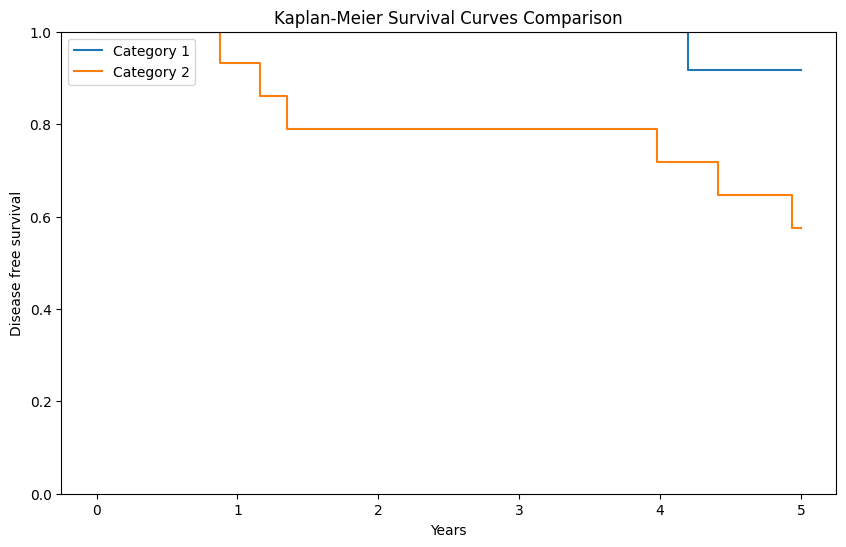

In [ ]:
import matplotlib.pyplot as plt

# Create a Kaplan-Meier fitter for each group
kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()

# Fit the data
kmf1.fit(durations=group1['DFS'], event_observed=group1['Event'], label='Category 1')
kmf2.fit(durations=group2['DFS'], event_observed=group2['Event'], label='Category 2')

# Plot the survival curves without confidence intervals
plt.figure(figsize=(10, 6))
kmf1.plot_survival_function(ci_show=False)
kmf2.plot_survival_function(ci_show=False)
plt.title('Kaplan-Meier Survival Curves Comparison')
plt.xlabel('Years')
plt.ylabel('Disease free survival')
plt.ylim(0.0, 1.0)  # Set y-axis limits
plt.legend()
plt.show()



In [ ]:
import numpy as np

# Define time points where you want to evaluate the survival
time_points = [0, 1, 2, 3, 4, 5]

# Calculate the number of survivors at each time point
survivors_group1 = [kmf1.survival_function_at_times(t) * len(group1) for t in time_points]
survivors_group2 = [kmf2.survival_function_at_times(t) * len(group2) for t in time_points]

# Convert the number of survivors to integers (since you cannot have a fraction of a person surviving)
survivors_group1 = [int(round(s.iloc[0])) for s in survivors_group1]
survivors_group2 = [int(round(s.iloc[0])) for s in survivors_group2]

# Create a DataFrame to hold the results
survivor_data = pd.DataFrame({
    'Time': time_points,
    'Survivors in Group 1': survivors_group1,
    'Survivors in Group 2': survivors_group2
})

# Display the DataFrame
print(survivor_data)

# Output to Excel
survivor_data.to_excel('survival_data.xlsx', index=False)


   Time  Survivors in Group 1  Survivors in Group 2
0     0                    13                    16
1     1                    13                    15
2     2                    13                    13
3     3                    13                    13
4     4                    13                    11
5     5                    12                     9


In [ ]:
import pandas as pd
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
from itertools import product

# Load the data
df = pd.read_excel('JSCCR fStageII.xlsx')

# Correct the encoding for event occurrence
df['Event'] = df['Event'].map({1: 0, 2: 1})

# Set category variables
df['pDepth_category'] = df['pDepth'].map({1: 'SS', 2: 'SE', 3: 'SI'})
df['v_category'] = df['v'].map({1: 'v-', 2: 'v+'})
df['LN_number_category'] = df['LN number'].map({1: '>=12', 2: '0-11'})
df['Pathology_category'] = df['Pathology'].map({1: 'tub1, pap', 2: 'tub2', 3: 'por, sig, undiff'})
df['ly_category'] = df['ly'].map({1: 'ly-', 2: 'ly+'})
df['CEA_category'] = df['CEA'].map({1: 'Below Cutoff', 2: 'Above Cutoff'})

# Fix pDepth to 'SE'
df = df[df['pDepth_category'] == 'SE']

# Instantiate Kaplan-Meier Fitter
kmf = KaplanMeierFitter()

# List to store the results
results = []

# Loop through all combinations
for pathology, ly, v, cea, ln_number in product(df['Pathology_category'].unique(), df['ly_category'].unique(), df['v_category'].unique(), df['CEA_category'].unique(), df['LN_number_category'].unique()):
    # Filtering
    filtered_df = df[(df['Pathology_category'] == pathology) & (df['ly_category'] == ly) & (df['v_category'] == v) & (df['CEA_category'] == cea) & (df['LN_number_category'] == ln_number)]
    n_patients = len(filtered_df)

    # Calculate survival rates only if there are more than 0 cases
    if n_patients > 0:
        kmf.fit(durations=filtered_df['DFS'], event_observed=filtered_df['Event'])
        five_year_dfs = kmf.predict(5)
        results.append([pathology, ly, v, cea, ln_number, five_year_dfs * 100, n_patients])

# Convert results to a DataFrame
results_df = pd.DataFrame(results, columns=['Pathology', 'ly', 'v', 'CEA', 'LN number', '5-Year DFS (%)', 'N'])

# Output the results to an Excel file
results_df.to_excel('5_year_survival_rates.xlsx', index=False)


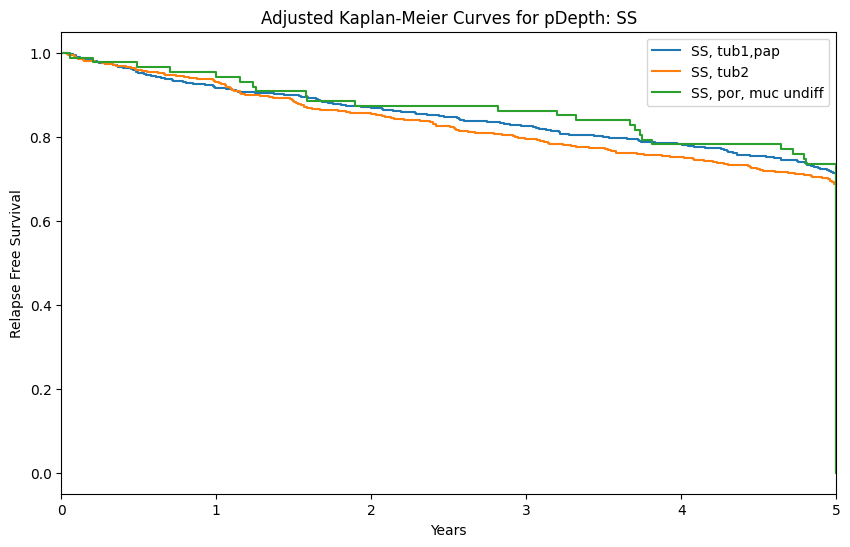

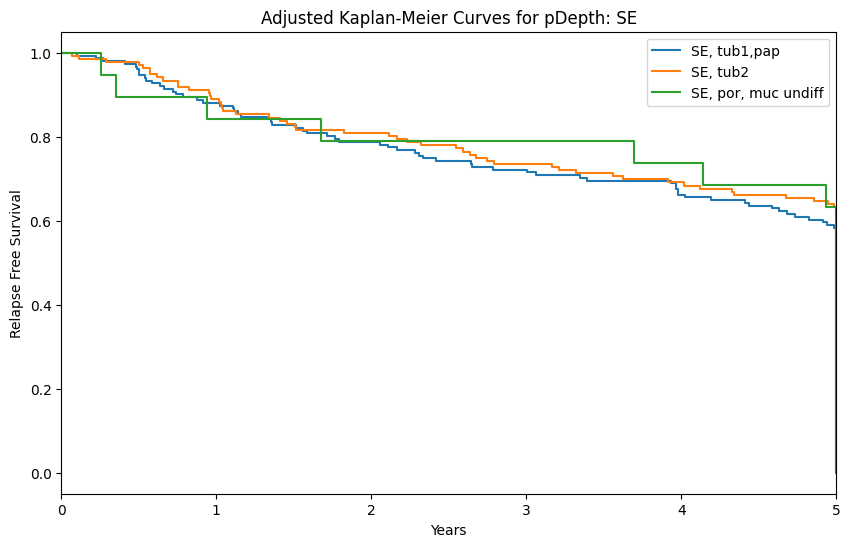

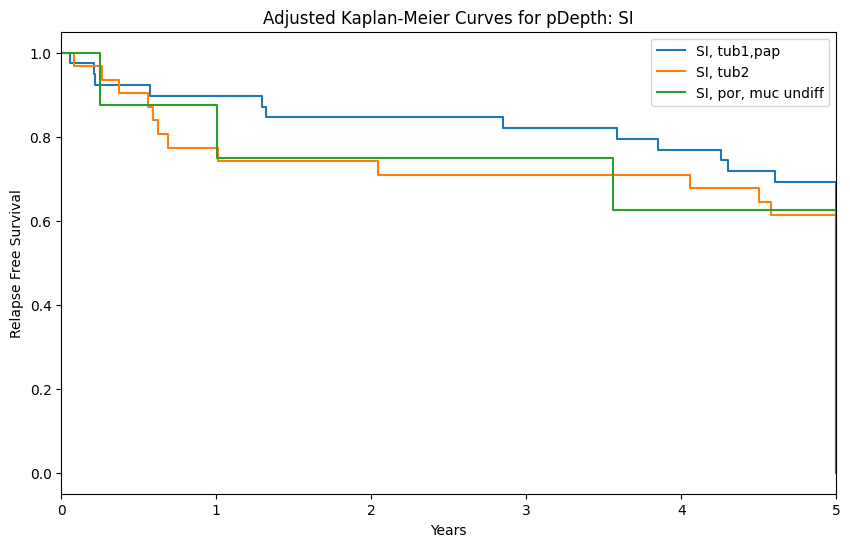

Log Rank Test between SS tub1,pap and SS tub2:
   test_statistic         p  -log2(p)
0        1.212071  0.270922  1.884048

Log Rank Test between SS tub1,pap and SS por, muc undiff:
   test_statistic         p  -log2(p)
0        0.266211  0.605885  0.722884

Log Rank Test between SS tub2 and SS por, muc undiff:
   test_statistic         p  -log2(p)
0         1.00243  0.316723  1.658706
Log Rank Test between SE tub1,pap and SE tub2:
   test_statistic         p  -log2(p)
0        0.632432  0.426465  1.229502

Log Rank Test between SE tub1,pap and SE por, muc undiff:
   test_statistic         p  -log2(p)
0        0.145274  0.703094  0.508211

Log Rank Test between SE tub2 and SE por, muc undiff:
   test_statistic         p  -log2(p)
0        0.000029  0.995702  0.006214
Log Rank Test between SI tub1,pap and SI tub2:
   test_statistic         p  -log2(p)
0        0.571719  0.449577  1.153361

Log Rank Test between SI tub1,pap and SI por, muc undiff:
   test_statistic         p  -log2(p)
0 

In [ ]:
import pandas as pd
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt
from lifelines.utils import median_survival_times

# Load the data
data = pd.read_excel('JSCCR fStageII.xlsx')

# Convert the variables for pDepth and Pathology
pdepth_mapping = {1: 'SS', 2: 'SE', 3: 'SI'}
Pathology_mapping = {1: 'tub1,pap', 2: 'tub2', 3: 'por, muc undiff'}
data['pDepth'] = data['pDepth'].map(pdepth_mapping)
data['Pathology'] = data['Pathology'].map(Pathology_mapping)

# Plot the Kaplan-Meier curves
kmf = KaplanMeierFitter()

def plot_km_curves_adjusted(data, pdepth_value):
    plt.figure(figsize=(10, 6))
    for Pathology_group in data['Pathology'].unique():
        group = data[(data['pDepth'] == pdepth_value) & (data['Pathology'] == Pathology_group)]
        kmf.fit(group['DFS'], event_observed=group['Event'])

        # Obtain median survival and use it to limit the x-axis, if needed
        median_surv = median_survival_times(kmf.confidence_interval_)

        # Plotting
        ax = kmf.plot(ci_show=False, label=f'{pdepth_value}, {Pathology_group}')
        plt.xlim(0, min(max(group['DFS']), 5)) # Adjusting x-axis to max duration or 5 years

    plt.title(f"Adjusted Kaplan-Meier Curves for pDepth: {pdepth_value}")
    plt.xlabel("Years")
    plt.ylabel("Relapse Free Survival")
    plt.legend()
    plt.show()

# Example usage
for pdepth in ['SS', 'SE', 'SI']:
    plot_km_curves_adjusted(data, pdepth)


# Log Rank Test
# Example: Analysis for SS
group1 = data[(data['pDepth'] == 'SS') & (data['Pathology'] == 'tub1,pap')]
group2 = data[(data['pDepth'] == 'SS') & (data['Pathology'] == 'tub2')]
group3 = data[(data['pDepth'] == 'SS') & (data['Pathology'] == 'por, muc undiff')]

# Execute the Log Rank Test
results_SS = logrank_test(group1['DFS'], group2['DFS'], event_observed_A=group1['Event'], event_observed_B=group2['Event'])
print("Log Rank Test between SS tub1,pap and SS tub2:")
print(results_SS.summary)

results_SS_2 = logrank_test(group1['DFS'], group3['DFS'], event_observed_A=group1['Event'], event_observed_B=group3['Event'])
print("\nLog Rank Test between SS tub1,pap and SS por, muc undiff:")
print(results_SS_2.summary)

results_SS_3 = logrank_test(group2['DFS'], group3['DFS'], event_observed_A=group2['Event'], event_observed_B=group3['Event'])
print("\nLog Rank Test between SS tub2 and SS por, muc undiff:")
print(results_SS_3.summary)

# Log Rank Test
# Example: Analysis for SE
group1 = data[(data['pDepth'] == 'SE') & (data['Pathology'] == 'tub1,pap')]
group2 = data[(data['pDepth'] == 'SE') & (data['Pathology'] == 'tub2')]
group3 = data[(data['pDepth'] == 'SE') & (data['Pathology'] == 'por, muc undiff')]

# Execute the Log Rank Test
results_SS = logrank_test(group1['DFS'], group2['DFS'], event_observed_A=group1['Event'], event_observed_B=group2['Event'])
print("Log Rank Test between SE tub1,pap and SE tub2:")
print(results_SS.summary)

results_SS_2 = logrank_test(group1['DFS'], group3['DFS'], event_observed_A=group1['Event'], event_observed_B=group3['Event'])
print("\nLog Rank Test between SE tub1,pap and SE por, muc undiff:")
print(results_SS_2.summary)

results_SS_3 = logrank_test(group2['DFS'], group3['DFS'], event_observed_A=group2['Event'], event_observed_B=group3['Event'])
print("\nLog Rank Test between SE tub2 and SE por, muc undiff:")
print(results_SS_3.summary)


# Log Rank Test
# Example: Analysis for SI
group1 = data[(data['pDepth'] == 'SI') & (data['Pathology'] == 'tub1,pap')]
group2 = data[(data['pDepth'] == 'SI') & (data['Pathology'] == 'tub2')]
group3 = data[(data['pDepth'] == 'SI') & (data['Pathology'] == 'por, muc undiff')]

# Execute the Log Rank Test
results_SS = logrank_test(group1['DFS'], group2['DFS'], event_observed_A=group1['Event'], event_observed_B=group2['Event'])
print("Log Rank Test between SI tub1,pap and SI tub2:")
print(results_SS.summary)

results_SS_2 = logrank_test(group1['DFS'], group3['DFS'], event_observed_A=group1['Event'], event_observed_B=group3['Event'])
print("\nLog Rank Test between SI tub1,pap and SI por, muc undiff:")
print(results_SS_2.summary)

results_SS_3 = logrank_test(group2['DFS'], group3['DFS'], event_observed_A=group2['Event'], event_observed_B=group3['Event'])
print("\nLog Rank Test between SI tub2 and SI por, muc undiff:")
print(results_SS_3.summary)



